In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt

In [3]:
TRAIN_DIR = "chest_xray/train/"
TEST_DIR =  "chest_xray/test/"

# Preprocessing data

In [4]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [5]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [6]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 3884/3884 [12:37<00:00,  5.13it/s]


In [8]:
X_test , y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:54<00:00,  7.15it/s]


# One-hot Encoding

In [9]:
#np.utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.

from keras.utils import to_categorical

y_train = to_categorical(y_train,2)
y_test = to_categorical(y_test,2) 

Using TensorFlow backend.
C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Asus\Anaconda3\envs\tensor

In [11]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

In [12]:
def plotter(i):
    imagep1 = cv2.imread("{0}{1}{2}".format(TRAIN_DIR, "PNEUMONIA/", Pimages[i]))
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread("{0}{1}{2}".format(TRAIN_DIR, "NORMAL/", Nimages[i]))
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3), mode = 'reflect')
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("No Pneumonia Vs Pneumonia")
    print("---------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(5,5))
    plt.imshow(pair)
    plt.show()

# Visualizing the data set images

No Pneumonia Vs Pneumonia
---------------------------------------------------------------------------------------------------------------


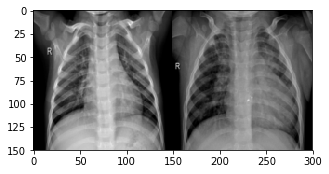

No Pneumonia Vs Pneumonia
---------------------------------------------------------------------------------------------------------------


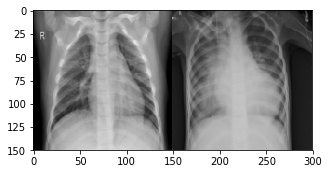

No Pneumonia Vs Pneumonia
---------------------------------------------------------------------------------------------------------------


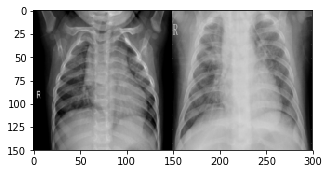

No Pneumonia Vs Pneumonia
---------------------------------------------------------------------------------------------------------------


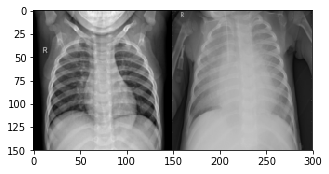

No Pneumonia Vs Pneumonia
---------------------------------------------------------------------------------------------------------------


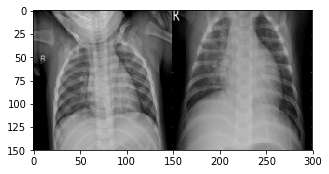

In [13]:
for i in range(4,9):
    plotter(i)

Training data  (5232, 2)


Text(0.5,1,'Plot of the number of samples of each class in the training set')

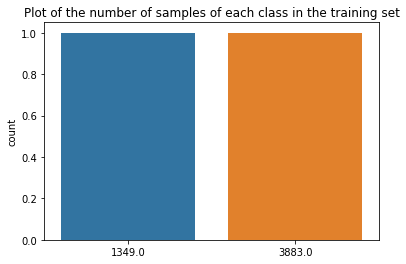

In [14]:
import seaborn as sns
print("Training data ",y_train.shape)

count = y_train.sum(axis=0)
sns.countplot(x=count)
plt.title("Plot of the number of samples of each class in the training set")

Testing data  (624, 2)


Text(0.5,1,'Plot of the number of samples of each class in the test set')

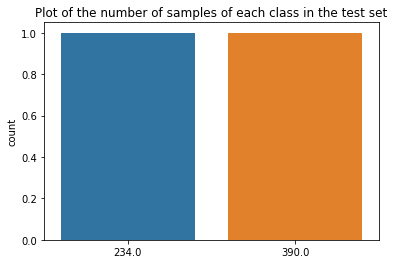

In [15]:
count = y_test.sum(axis = 0)
print("Testing data ",y_test.shape)
sns.countplot(x = count)
plt.title("Plot of the number of samples of each class in the test set")

In [16]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [17]:
filepath="weights_batchnorm_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.common.image_dim_ordering()
K.common.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
print("Training Set :")
print(X_train.shape )
print(y_train.shape )
print("\n TestingSet :")
print(X_test.shape )
print(y_test.shape )

Training Set :
(5232, 150, 150, 3)
(5232, 2)

 TestingSet :
(624, 150, 150, 3)
(624, 2)


In [20]:
X_train=X_train.reshape(5232,3,150,150)
X_test=X_test.reshape(624,3,150,150)

Normalize the data

In [21]:
# we divide on 255 for data normalisation
X_train = X_train/255.0
X_test = X_test/255.0

# CNN Architecture

In [22]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150), dim_ordering="th"))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu', dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150), dim_ordering="th"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same", dim_ordering="th"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu', dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same", dim_ordering="th"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu', dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same", dim_ordering="th"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu', dim_ordering="th"))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(BatchNormalization())
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00008),
                  metrics=['accuracy'])

print(model.summary())

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", input_shape=(3, 150, 1..., data_format="channels_first")`
  """


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", activation="relu", data_format="channels_first")`
  
C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  import sys
C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(3, 150, 1..., data_format="channels_first")`
  if __name__ == '__main__':
C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_first")`
  # Remove the CWD from sys.path

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 37, 37)       

In [53]:
batch_size = 32
epochs = 10

import gc
gc.collect()

20889

In [24]:
#import os
#os.environ['THEANO_FLAGS'] = 'optimizer=None'

In [54]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5232 samples, validate on 624 samples
Epoch 1/10
5232/5232 [==============================] - 568s 109ms/step - loss: 0.1477 - accuracy: 0.9425 - val_loss: 5.3078 - val_accuracy: 0.6250
Epoch 2/10
5232/5232 [==============================] - 427s 82ms/step - loss: 0.1417 - accuracy: 0.9467 - val_loss: 4.3943 - val_accuracy: 0.6250
Epoch 3/10
5232/5232 [==============================] - 417s 80ms/step - loss: 0.1465 - accuracy: 0.9455 - val_loss: 0.7740 - val_accuracy: 0.7115
Epoch 4/10
5232/5232 [==============================] - 411s 79ms/step - loss: 0.1375 - accuracy: 0.9486 - val_loss: 3.5697 - val_accuracy: 0.6306
Epoch 5/10
5232/5232 [==============================] - 416s 80ms/step - loss: 0.1390 - accuracy: 0.9450 - val_loss: 5.1465 - val_accuracy: 0.3750
Epoch 6/10
5232/5232 [==============================] - 410s 78ms/step - loss: 0.1343 - accuracy: 0.9493 - val_loss: 0.6681 - val_accuracy: 0.7524
Epoch 7/10
5232/5232 [==============================] - 9310s 2s/step 

# Model statistics

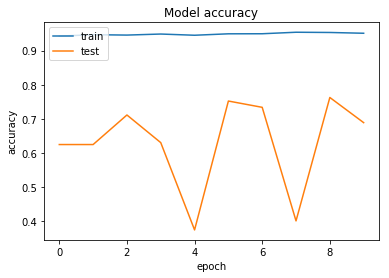

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


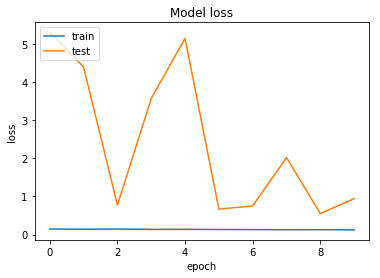

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [58]:
acc = accuracy_score(y_true, pred)*100
CM = confusion_matrix(y_true, pred)
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
#fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
#plt.title("Confusion Matrix")
print(acc)
print(CM)
plt.show()

68.91025641025641
[[226   8]
 [186 204]]


In [59]:
def get_metric(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = float(tp)/(tp+fp)*100
    recall = float(tp)/(tp+fn)*100
    return precision, recall

precision, recall = get_metric(CM)
print('\nTEST METRICS ----------------------')
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
f1_score = 2*(precision*recall)/precision+recall
print("F1 score of the model is {:.2f}".format(f1_score))





TEST METRICS ----------------------
Recall of the model is 52.31
Precision of the model is 96.23
F1 score of the model is 156.92
